# Introduction

- dataset: https://www.kaggle.com/birdy654/environment-recognition-simulation-to-reality

## References

- [From Simulation to Reality: CNN Transfer Learning for Scene Classification
](https://www.researchgate.net/publication/338868329_From_Simulation_to_Reality_CNN_Transfer_Learning_for_Scene_Classification)

---

Classes:

0. Living Room (interior)
1. Bathroom (interior)
2. Staircase (interior)
3. Forest (exterior)
4. Field (exterior)
5. Computer Lab (interior)

In [3]:
import collections
import copy
import glob
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm

import torch
import torch.nn as nn
import torchvision
import torchvision.utils as utils
import torchvision.models as models
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

In [4]:
np.random.rand(0)
plt.style.use("fivethirtyeight")

## Data Preprocessing

Our goal now is to read in the data and process them appropriately.
We will do the following:

1. Access the image data (both real and virtual)
2. Read the images into `np.ndarray`s and reshape into 32x32
3. Populate two dictionaries with data
4. Randomize the dictionaries values
6. Display a few images
7. Equalize datasets both per class (real, virtual) and per category (Living Room (interior), Bathroom (interior), etc.)
8. Prepare the preprocessed dataset for training (80/20 split for train/test)

## Defining Reusable Variables

We will start be defining variables that will be useful in the future and
whose values will not change throughout our experiments.

In [5]:
from typing import Dict, List, Tuple


# Define the classes mapping
classes: Dict[int, str] = {
    "LIVING_ROOM_INTERIOR": 0,
    "BATHROOM_INTERIOR": 1,
    "STAIRCASE_INTERIOR": 2,
    "FOREST_EXTERIOR": 3,
    "FIELD_EXTERIOR": 4,
    "COMPUTER_LAB_INTERIOR": 5,
}

# Image dimensions
dims: Tuple[int, int] = (64, 64)

# Directory paths
real_path: str = "/kaggle/input/dataset-test/data/real"
virt_path: str = "/kaggle/input/dataset-test/data/virtual"

# Categories withing directories
dirs: List[int] = classes.keys()

## Loading Image Data

We first start by loading the data. Despite the fact that all images might not
be of the same dimension, we will resize them while reading and make them 32x32.
It is also important to shuffle the data after reading them from the disk. This
way we avoid the potential bias from the dataset designer.

In [6]:
# Real and virtual images
real = collections.defaultdict(list)
virt = collections.defaultdict(list)

# Populate the dictionaries
for dir in tqdm.tqdm(dirs):
    # Real images
    for img in glob.glob(f"{real_path}/{dir}/*.jpg"):
        real[dir].append(cv2.resize(cv2.imread(img), dims))
    np.random.shuffle(real[dir])

    # Virtual images
    for img in glob.glob(f"{virt_path}/{dir}/*.png"):
        virt[dir].append(cv2.resize(cv2.imread(img), dims))
    np.random.shuffle(virt[dir])

# Report the current statistics
print(f"Real: {len(real)} classes, {sum(map(len, real.values())):,} total samples")
print(f"Virtual: {len(virt)} classes, {sum(map(len, virt.values())):,} total samples")

100%|██████████| 6/6 [01:24<00:00, 14.13s/it]

Real: 6 classes, 3,013 total samples
Virtual: 6 classes, 5,928 total samples


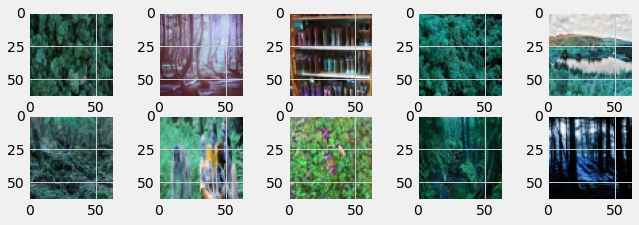

In [7]:
def show_images(imgs: List[np.ndarray], cols: int = 5) -> None:
    """A function to display images inline."""

    plt.figure(figsize=(10, 5))
    for idx, img in enumerate(imgs):
        plt.subplot(len(imgs) // cols + 1, cols, idx + 1)
        plt.imshow(img)

# Display 10 forest images across two rows
show_images(real["FOREST_EXTERIOR"][:10])

## Category Sizes

As already mentioned, we have 6 categories for both classes. For machine learning
and deep learning purposes, it is preferred to have equal number of samples per category.
The code below equalizes the number of samples per category.

In [8]:
# Get the minimum number of images per category for real and virtual images
min_real: int = min(list(map(len, real.values())))
min_virt: int = min(list(map(len, virt.values())))
min_global: int = min(min_real, min_virt)

# Remove the images
for dir in tqdm.tqdm(dirs):
    for _ in range(len(real[dir]) - min_global):
        real[dir].pop()
    for _ in range(len(virt[dir]) - min_global):
        virt[dir].pop()

# Make sure that both categories have the same number of samples per category
for dir in dirs:
    assert len(real[dir]) == len(virt[dir])

# Report the results
print(f"Number of samples per category for real-world and virtual images: {min_global:,}")

100%|██████████| 6/6 [00:00<00:00, 937.41it/s]

Number of samples per category for real-world and virtual images: 369


## Image Classification

We first use a traditional classification technique - SGD and then compare its performance
to a deep learning approach - Convolutional Neural Network (CNN).

## Convolutional Neural Networks

We will be using PyTorch for building CNNs. In PyTorch, machine learning models
are often represented as classes (as shown below). It has a single method, `forward`,
which performs a forward propagation in the network. Backward pass is handled by
PyTorch as it has a built-in reverse-mode automatic differentiation (i.e.,
derivatives are computed on the fly by recording network operations during
the forward propagation).

In [9]:
# WE NEED DATA AUGMNETATION: It is a process of transforming an image by a
# small amount (be it height, width, rotation etc or any combination of these).
# In this way, an image and its augmented image will differ slightly.

augmented_real = collections.defaultdict(list)
augmented_virt = collections.defaultdict(list)

# Append 90, 180, and 270 rotations
for key, val in tqdm.tqdm(real.items()):
    for img in val:
        augmented_real[key].append(img)
        augmented_real[key].append(np.rot90(img, 1))
        augmented_real[key].append(np.rot90(img, 2))
        augmented_real[key].append(np.rot90(img, 3))
    np.random.shuffle(augmented_real[key])

# Append 90, 180, and 270 rotations
for key, val in tqdm.tqdm(virt.items()):
    for img in val:
        augmented_virt[key].append(img)
        augmented_virt[key].append(np.rot90(img, 1))
        augmented_virt[key].append(np.rot90(img, 2))
        augmented_virt[key].append(np.rot90(img, 3))
    np.random.shuffle(augmented_virt[key])
        
real = augmented_real
virt = augmented_virt

100%|██████████| 6/6 [00:00<00:00, 38.54it/s]


In [10]:
# Store all images
all: Dict[str, list] = {key: [] for key in classes}

# Add real images
for key, val in tqdm.tqdm(real.items()):
    for img in val:
        all[key].append(img)

# Add virtual images
for key, val in tqdm.tqdm(virt.items()):
    for img in val:
        all[key].append(img)

100%|██████████| 6/6 [00:00<00:00, 2021.35it/s]


### Train and test split for `real` (real images), `virt` (virtual images), `all` (both real and virtual images)

In [11]:
# Images and labels for real images
x_real: List[np.ndarray] = []
y_real: List[int] = []
for key, vals in tqdm.tqdm(real.items()):
    for val in vals:
        # Flatten the values before appending
        x_real.append(val)
        y_real.append(classes[key])

# Images and labels for virtual images
x_virt: List[np.ndarray] = []
y_virt: List[int] = []
for key, vals in tqdm.tqdm(virt.items()):
    for val in vals:
        # Flatten the values before appending
        x_virt.append(val)
        y_virt.append(classes[key])
        
# Images and labels for all images
x_all: List[np.ndarray] = []
y_all: List[int] = []
for key, vals in tqdm.tqdm(all.items()):
    for val in vals:
        # Flatten the values before appending
        x_all.append(val)
        y_all.append(classes[key])

# Make sure the assertion holds (once again)
assert len(x_real) == len(y_real) == 4 * len(classes) * min_global == len(x_virt) == len(y_virt) == 4 * len(classes) * min_global

# Test and train split (80% for training and 20% for testing)
x_real_train, x_real_test, y_real_train, y_real_test = train_test_split(x_real, y_real, test_size=0.2, random_state=0)
x_virt_train, x_virt_test, y_virt_train, y_virt_test = train_test_split(x_virt, y_virt, test_size=0.2, random_state=0)
x_all_train, x_all_test, y_all_train, y_all_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

# Report the number of samples
print(f"Real images: {len(x_real_train):,} for training and {len(x_real_test)} for testing")
print(f"Virtual images: {len(x_virt_train):,} for training and {len(x_virt_test)} for testing")
print(f"Virtual images: {len(x_all_train):,} for training and {len(x_all_test)} for testing")

100%|██████████| 6/6 [00:00<00:00, 744.33it/s]

Real images: 7,084 for training and 1772 for testing
Virtual images: 7,084 for training and 1772 for testing
Virtual images: 14,169 for training and 3543 for testing


In [12]:
# Convert images to PyTorch tensors
# PyTorch works only with NCHW image format
#
# NCHW stands for Number of Images, Channels (usually, 3), Height, and Width
real = {key: torch.as_tensor(val).permute(0, 3, 1, 2) for key, val in tqdm.tqdm(real.items())}
virt = {key: torch.as_tensor(val).permute(0, 3, 1, 2) for key, val in tqdm.tqdm(virt.items())}
all = {key: torch.as_tensor(val).permute(0, 3, 1, 2) for key, val in tqdm.tqdm(all.items())}

100%|██████████| 6/6 [02:19<00:00, 23.30s/it]


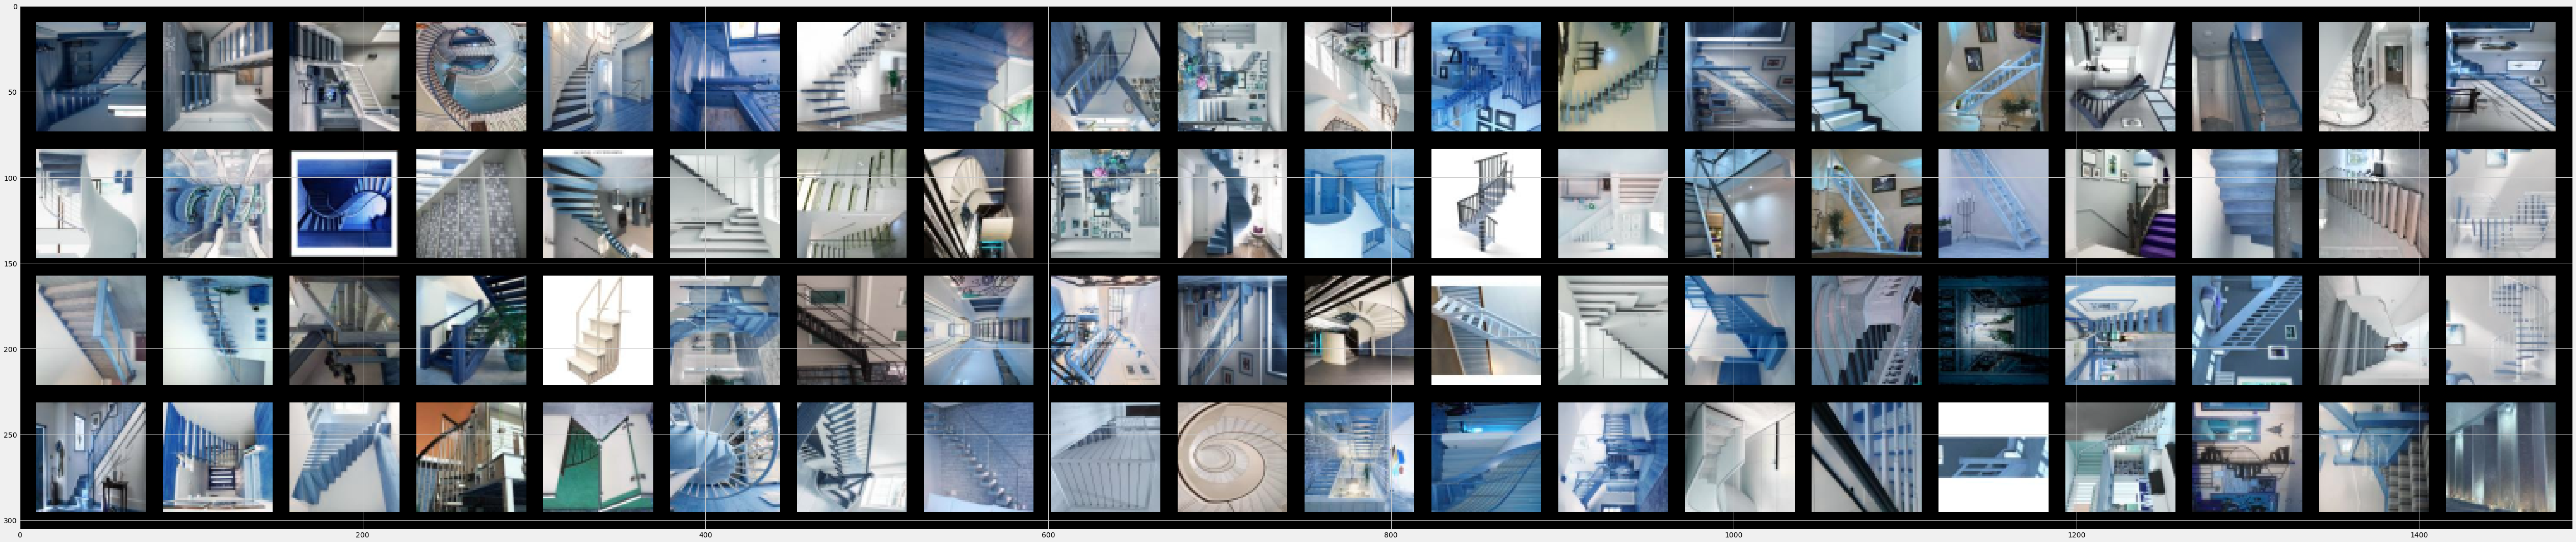

In [13]:
# For `make_grid` to work properly, images must be in channel-first layout (NCHW)
# On the other hand, `imshow` expects NHWC
def show_grid(images: torch.Tensor, num: int = 10) -> None:
    """Show `num` number of images in the form of a grid."""

    plt.figure(figsize=(num, num))
    img_grid = utils.make_grid(images[2 * num : 3 * num], nrow=num // 4, padding=10)
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.show()

# Randomly display real or virtual images
show_grid(np.random.choice([real, real])[np.random.choice(list(classes))], 80)

### Convolutional Neural Networks

We will do 80% for training and 20% for testing.

In [14]:
################################################################################
# Real Images
################################################################################

# Images and labels for real images
x_real: List[np.ndarray] = []
y_real: List[int] = []
for key, vals in tqdm.tqdm(real.items()):
    for val in vals:
        # Flatten the values before appending
        x_real.append(val.float())
        y_real.append(classes[key])

# Train/test
x_real_train, x_real_test, y_real_train, y_real_test = train_test_split(x_real, y_real, test_size=0.2, random_state=53)

# Datasets
real_image_datasets = {"train": list(zip(x_real_train, y_real_train)), "test": list(zip(x_real_test, y_real_test))}

################################################################################
# Virtual Images
################################################################################

# Images and labels for real images
x_virt: List[np.ndarray] = []
y_virt: List[int] = []
for key, vals in tqdm.tqdm(virt.items()):
    for val in vals:
        # Flatten the values before appending
        x_virt.append(val.float())
        y_virt.append(classes[key])

# Train/test
x_virt_train, x_virt_test, y_virt_train, y_virt_test = train_test_split(x_virt, y_virt, test_size=0.2, random_state=53)

# Datasets
virt_image_datasets = {"train": list(zip(x_virt_train, y_virt_train)), "test": list(zip(x_virt_test, y_virt_test))}

################################################################################
# All Images
################################################################################

# Images and labels for real images
x_all: List[np.ndarray] = []
y_all: List[int] = []
for key, vals in tqdm.tqdm(all.items()):
    for val in vals:
        # Flatten the values before appending
        x_all.append(val.float())
        y_all.append(classes[key])

# Train/test
x_all_train, x_all_test, y_all_train, y_all_test = train_test_split(x_all, y_all, test_size=0.2, random_state=53)

# Datasets
all_image_datasets = {"train": list(zip(x_all_train, y_all_train)), "test": list(zip(x_all_test, y_all_test))}

100%|██████████| 6/6 [00:00<00:00,  8.44it/s]


In [15]:
# Device (IMPORTANT!! NEED TO TRAIN ON GPU!)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
def train(net, dataset, epochs: int, debug: bool = True) -> None:
    """Training function."""
    
    print("Started training!")

    # Training: loop over the dataset multiple times
    for epoch in range(epochs):
        if debug:
            running_loss = 0.0
        for i, data in enumerate(dataset, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data[0].to(DEVICE)
            labels = data[1].to(DEVICE)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if debug:
                # print statistics
                running_loss += loss.item()
                # print every 500 mini-batches
                if i % 500 == 499:
                    print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 500:.2f}")
                    running_loss = 0.0

    print("Done!")

In [18]:
def test(net, dataset) -> None:
    """Test the accuracy of the model."""

    correct = 0
    total = 0
    preds = []
    actual = []
    with torch.no_grad():
        for images, labels in dataset:
            actual.extend(labels.cpu().numpy())
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            preds.extend(list(predicted.cpu().numpy()))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(classification_report(actual, preds))

## Using VGG

In [19]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(2048, 185)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [23]:
################################################################################
# Real Images
################################################################################

# Dataloader
real_dataloader = {
    x: torch.utils.data.DataLoader(
        real_image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    )
    for x in ["train", "test"]
}

# Define the model
realnet = VGG("VGG19")
realnet.to(DEVICE)

# Loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(realnet.parameters(), lr=3e-4)

# Training
train(realnet, real_dataloader["train"], epochs=25)

# Test
test(realnet, real_dataloader["test"])

Started training!
[1, 500] loss: 1.96
[1, 1000] loss: 1.71
[1, 1500] loss: 1.64
[2, 500] loss: 1.57
[2, 1000] loss: 1.49
[2, 1500] loss: 1.50
[3, 500] loss: 1.45
[3, 1000] loss: 1.45
[3, 1500] loss: 1.37
[4, 500] loss: 1.31
[4, 1000] loss: 1.28
[4, 1500] loss: 1.19
[5, 500] loss: 1.14
[5, 1000] loss: 1.13
[5, 1500] loss: 1.08
[6, 500] loss: 1.02
[6, 1000] loss: 1.06
[6, 1500] loss: 1.00
[7, 500] loss: 0.95
[7, 1000] loss: 0.94
[7, 1500] loss: 0.94
[8, 500] loss: 0.88
[8, 1000] loss: 0.91
[8, 1500] loss: 0.88
[9, 500] loss: 0.86
[9, 1000] loss: 0.85
[9, 1500] loss: 0.82
[10, 500] loss: 0.77
[10, 1000] loss: 0.82
[10, 1500] loss: 0.82
[11, 500] loss: 0.76
[11, 1000] loss: 0.76
[11, 1500] loss: 0.74
[12, 500] loss: 0.74
[12, 1000] loss: 0.73
[12, 1500] loss: 0.69
[13, 500] loss: 0.70
[13, 1000] loss: 0.68
[13, 1500] loss: 0.68
[14, 500] loss: 0.64
[14, 1000] loss: 0.68
[14, 1500] loss: 0.64
[15, 500] loss: 0.63
[15, 1000] loss: 0.64
[15, 1500] loss: 0.63
[16, 500] loss: 0.59
[16, 1000] lo

In [22]:
################################################################################
# Virtual Images
################################################################################

# Dataloader
virt_dataloader = {
    x: torch.utils.data.DataLoader(
        virt_image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    )
    for x in ["train", "test"]
}

# Define the model
virtnet = VGG("VGG19")
virtnet.to(DEVICE)

# Loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(virtnet.parameters(), lr=3e-4)

# Training
train(virtnet, virt_dataloader["train"], epochs=25)

# Test
test(virtnet, virt_dataloader["test"])

Started training!
[1, 500] loss: 1.86
[1, 1000] loss: 1.55
[1, 1500] loss: 1.43
[2, 500] loss: 1.31
[2, 1000] loss: 1.26
[2, 1500] loss: 1.23
[3, 500] loss: 1.16
[3, 1000] loss: 1.09
[3, 1500] loss: 1.07
[4, 500] loss: 1.00
[4, 1000] loss: 0.94
[4, 1500] loss: 0.85
[5, 500] loss: 0.80
[5, 1000] loss: 0.76
[5, 1500] loss: 0.74
[6, 500] loss: 0.66
[6, 1000] loss: 0.60
[6, 1500] loss: 0.59
[7, 500] loss: 0.54
[7, 1000] loss: 0.50
[7, 1500] loss: 0.48
[8, 500] loss: 0.45
[8, 1000] loss: 0.47
[8, 1500] loss: 0.41
[9, 500] loss: 0.40
[9, 1000] loss: 0.40
[9, 1500] loss: 0.38
[10, 500] loss: 0.35
[10, 1000] loss: 0.35
[10, 1500] loss: 0.37
[11, 500] loss: 0.32
[11, 1000] loss: 0.32
[11, 1500] loss: 0.31
[12, 500] loss: 0.31
[12, 1000] loss: 0.30
[12, 1500] loss: 0.25
[13, 500] loss: 0.27
[13, 1000] loss: 0.31
[13, 1500] loss: 0.28
[14, 500] loss: 0.25
[14, 1000] loss: 0.27
[14, 1500] loss: 0.20
[15, 500] loss: 0.21
[15, 1000] loss: 0.22
[15, 1500] loss: 0.22
[16, 500] loss: 0.21
[16, 1000] lo

In [20]:
################################################################################
# All Images
################################################################################

# Dataloader
all_dataloader = {
    x: torch.utils.data.DataLoader(
        all_image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    )
    for x in ["train", "test"]
}

# Define the model
allnet = VGG("VGG19")
allnet.to(DEVICE)

# Loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(allnet.parameters(), lr=3e-4)

# Training
train(allnet, all_dataloader["train"], epochs=50)

# Test
test(allnet, all_dataloader["test"])

Started training!
[1, 500] loss: 1.97
[1, 1000] loss: 1.70
[1, 1500] loss: 1.65
[1, 2000] loss: 1.60
[1, 2500] loss: 1.52
[1, 3000] loss: 1.46
[1, 3500] loss: 1.47
[2, 500] loss: 1.45
[2, 1000] loss: 1.42
[2, 1500] loss: 1.36
[2, 2000] loss: 1.29
[2, 2500] loss: 1.32
[2, 3000] loss: 1.26
[2, 3500] loss: 1.18
[3, 500] loss: 1.18
[3, 1000] loss: 1.15
[3, 1500] loss: 1.10
[3, 2000] loss: 1.11
[3, 2500] loss: 1.08
[3, 3000] loss: 1.00
[3, 3500] loss: 1.07
[4, 500] loss: 1.03
[4, 1000] loss: 0.95
[4, 1500] loss: 0.98
[4, 2000] loss: 0.98
[4, 2500] loss: 0.96
[4, 3000] loss: 0.97
[4, 3500] loss: 0.92
[5, 500] loss: 0.88
[5, 1000] loss: 0.92
[5, 1500] loss: 0.92
[5, 2000] loss: 0.87
[5, 2500] loss: 0.88
[5, 3000] loss: 0.84
[5, 3500] loss: 0.93
[6, 500] loss: 0.88
[6, 1000] loss: 0.84
[6, 1500] loss: 0.84
[6, 2000] loss: 0.85
[6, 2500] loss: 0.81
[6, 3000] loss: 0.80
[6, 3500] loss: 0.83
[7, 500] loss: 0.80
[7, 1000] loss: 0.76
[7, 1500] loss: 0.81
[7, 2000] loss: 0.79
[7, 2500] loss: 0.79
[7

In [24]:
# Save the models
torch.save(realnet, "./RealNet.pt")
torch.save(virtnet, "./VirtNet.pt")
torch.save(allnet, "./AllNet.pt")

In [26]:
!mkdir test
!mv AllNet.pt test
!mv VirtNet.pt test
!mv RealNet.pt test

In [32]:
!ls

[Errno 2] No such file or directory: 'test'
/kaggle/working/test
